#  Impact of Stomatal Resistance Parameterizations on Total Evapotranspiration in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

Clark et al.,(2015) explored the impact of stomatal resistance parameterizations on total Evapotranspiration that are simple soil resistance method, Ball Berry and Jarvis method in the reynolds mountain east. This Jupyter Notebook demonstrates how to repeat this study using the pySUMMA library.

## 2. Background

### The stomatal Resistance Parameterizations available in SUMMA

In [1]:
from IPython.display import display, Math, Latex

### 1) simple soil resistance method

   https://github.com/DavidChoi76/pysumma/blob/master/simple1.png

\begin{equation*}
r_{{s},{sun}} = r_{{s},{shd}} = \frac{r_{0c}}{\beta_v} \,\,\,\, 
\end{equation*}
$r_{0c} \,(s\,m^{-1})$ : the minimum stomatal resistance ,     ${\beta_v}\,(-)$ : the total soil water stress function

\begin{equation*}
{\beta_v} = \sum f_{{roots},{j}} \beta_{{v},{j}}  +  f_{roots}^{aq} \beta_{v}^{aq}
\end{equation*}
$z_{soil}$ : the soil depth, $f_{{roots},{j}}$ : the root density in the $j$-th soil layer
$\beta_{{v},{j}}$ : the water availability stress funtion in the $j$-th soil layer <br/>
$f_{roots}^{aq}$ : the fraction of roots for the aquifer, $\beta_{v}^{aq}$ : water availability stress function for the aquifer

### 2) Ball-Berry method
 
   https://github.com/DavidChoi76/pysumma/blob/master/BallBerry.png

\begin{equation*}
g_i = v_t  \frac{A_i}{c_{air}}\frac{e_{air}}{e_{sat}(T_{veg})}P_{air} + g_{min}\beta_v, \,\,\,\,   i = sun, shd
\end{equation*}

$g_i\, (micromol \,\, m^{-2} s^{-1})$ : Stomatal conductance per unit sunlit and shaded leaf area <br/> 
$A_i\, (micromol \,\, m^{-2} s^{-1})$ : a function of the rate of photosynthesis <br/>
$c_{air}\, (Pa)$ : $CO_2$ concentration at the leaf surface (time varying model forcing, representing carbon fertilization) <br/>
$g_{min}\, (micromol \,\, m^{-2} s^{-1})$ : the minimum stomatal conductance <br/>
$v_t\,(-)$ : an empirical parameter to relate transpiration to the $CO_2$ flux, where a greater value of $v_t$ means the leaf consumes more water to produce the same carbon mass <br/>

### 3) Jarvis method
    
   https://github.com/DavidChoi76/pysumma/blob/master/Jarvis.png

\begin{equation*}
r_{{s},{i}} = \frac{r_{0c}}{f(Q_{{PAR},{i}})f(T_{air})f(e_{d})\beta_v} \,\,\,\,   i = sun, shd
\end{equation*}

the subscript $i$ defines either sunlit or shaded leaves <br/> 
$f(Q_{{PAR},{i}})$, $f(T_{air})$, $f(e_{d})$ : all limited to the range 0-1, represent the effects of photosynthetically-active radiation(PAR), air temperature, and vapor pressure deficit, where $ Q_{{PAR},{i}} $ represents PAR absorbed on sunlit or shaded leaves <br/> 

<span style="color:blue"> __Above Stomal Resistance method from The structure for unifying multiple modeling alternatives (SUMMA), Version 1.0: Technical Description (April, 2005)__

## 3. Methods

### 1) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.
  - latitude : 43.2,      longitude : 243.2

In [2]:
import geopandas as gp
from jupyterthemes import jtplot

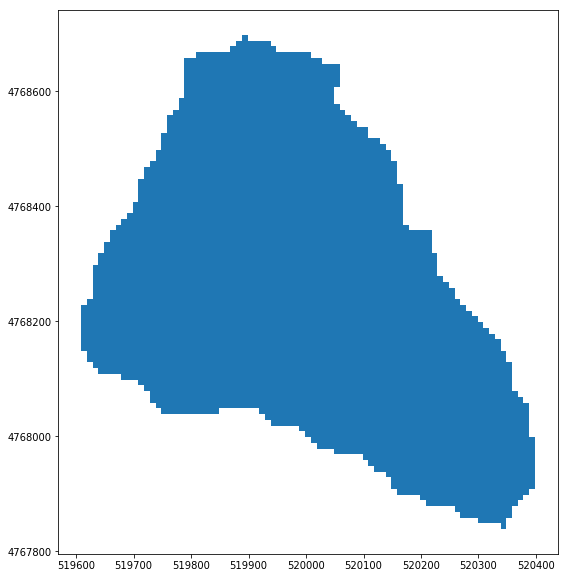

In [4]:
# set the figure size x(length), y(height)
jtplot.figsize(x=10, y=10)
# read study area shapefile in relative filepath 
gdf = gp.GeoDataFrame.from_file('../shape/ReynoldsMountainEast.shp')
# create plot of gdf attribute 
gdf.plot()

### 2) Create pySUMMA Simulation Object

In [5]:
from pysumma.Simulation import Simulation
# create pySUMMA Simulation Object in relative filepath 
S = Simulation('../summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_fileManager_riparianAspenSimpleResistance.txt')

#### 2-1) get a default value of a simulStart"name line in Decision text file ("decision_obj")

In [6]:
S.decision_obj.simulStart.value

'2006-07-01 00:00'

#### 2-2) set a value of a simulStart and a simulFinsh name line in Decision text file ("decision_obj") 

In [7]:
S.decision_obj.simulStart.value = "2007-07-01 00:00"
S.decision_obj.simulFinsh.value = "2007-08-20 00:00"

#### 2-3) get available options for stomatal resistance parameterization in Decision text file ("decision_obj") 

In [8]:
S.decision_obj.stomResist.options

['BallBerry', 'Jarvis', 'simpleResistance']

### 3) Run SUMMA model for Different Stomatal Resistance Parameterization Options

#### 3-1) get a default value of stomatal resistance options in Decision text file ("decision_obj") 

In [16]:
S.decision_obj.stomResist.value

'Jarvis'

#### 3-2) assign simple soil resistance method 

In [10]:
S.decision_obj.stomResist.value = 'simpleResistance'

#### 3-3) create S.executable attribute and Run SUMMA Model

In [11]:
S.executable = "../summa-master/bin/summa.exe"
results_simpleResistance = S.execute(run_suffix="simpleResistance")

#### 3-4) assign Ball Berry method and Run SUMMA Model

In [13]:
S.decision_obj.stomResist.value = 'BallBerry'
results_BallBerry = S.execute(run_suffix="BallBerry")

#### 3-5) assign Jarvis method and Run SUMMA Model

In [15]:
S.decision_obj.stomResist.value = 'Jarvis'
results_Jarvis = S.execute(run_suffix="Jarvis")

## 4. Result

### Plot ET for different Stomatal Resistance

In [17]:
from pysumma.Plotting import Plotting
import matplotlib.pyplot as plt
import pandas as pd
jtplot.figsize(x=10, y=10)

#### 1) Create a method to calculate Total Evapotranspiration

In [18]:
def calc_total_et(et_output_df):
    # Total Evapotranspiration = Canopy Transpiration + Canopy Evaporation + Ground Evaporation
    # Change unit from kgm-2s-1 to mm/hr (mulpitle 3600)
    total_et_data = (et_output_df['scalarCanopyTranspiration'] + et_output_df['scalarCanopyEvaporation'] + et_output_df['scalarGroundEvaporation'])*3600
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-06-01":"2007-08-20"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    return total_et_by_hour

#### 2) Get hour of day output of sthree stomatal resistance methods from 1 June to 20 August

In [19]:
simResis_hour = calc_total_et(results_simpleResistance)
BallBerry_hour = calc_total_et(results_BallBerry)
Jarvis_hour = calc_total_et(results_Jarvis)

#### 3) Plot ET for Simple Soil Resistance Method

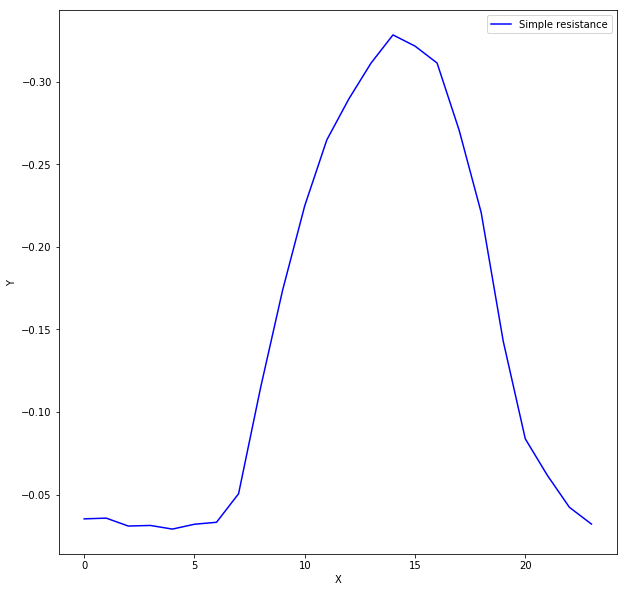

In [20]:
simResis_table = simResis_hour
# add label
simResis_table.columns = ['Simple resistance']
# add color
simResis_graph = simResis_table.plot(color='blue')
# add xlabel, ylabel
simResis_graph.set(xlabel='X', ylabel='Y')
# conver y axis
simResis_graph.invert_yaxis()

#### 4) Plot ET for Ball Berry Method

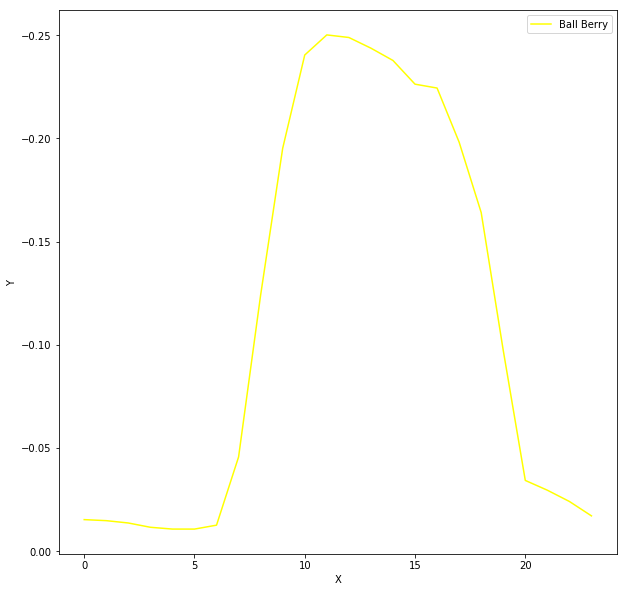

In [21]:
BallBerry_table = BallBerry_hour
BallBerry_table.columns = ['Ball Berry']
BallBerry_graph = BallBerry_table.plot(color='yellow')
BallBerry_graph.set(xlabel='X', ylabel='Y')
BallBerry_graph.invert_yaxis()

#### 5) Plot ET for Jarvis Method

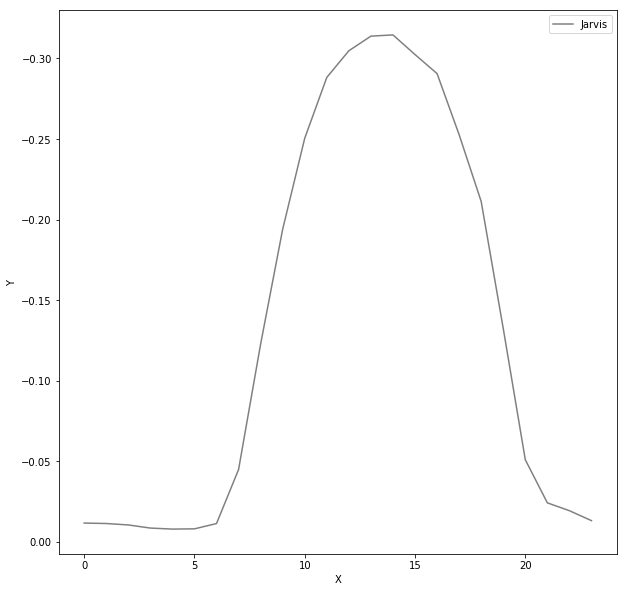

In [22]:
Jarvis_table = Jarvis_hour
Jarvis_table.columns = ['Jarvis']
Jarvis_graph = Jarvis_table.plot(color='gray')
Jarvis_graph.set(xlabel='X', ylabel='Y')
Jarvis_graph.invert_yaxis()

#### 6) Combine each stomatal resistance parameterizations

In [23]:
# Combine each stomatal resistance parameterizations
ET_Combine = pd.concat([simResis_hour, BallBerry_hour, Jarvis_hour], axis=1)
# add label 
ET_Combine.columns = ['Simple resistance', 'Ball-Berry', 'Jarvis']

In [24]:
ET_Combine

,Simple resistance,Ball-Berry,Jarvis
0,-0.035278,-0.015287,-0.011658
1,-0.035717,-0.014787,-0.011367
2,-0.030926,-0.013658,-0.010480
3,-0.031286,-0.011582,-0.008543
4,-0.029081,-0.010706,-0.007906
5,-0.032018,-0.010698,-0.008058
6,-0.033209,-0.012603,-0.011350
7,-0.050479,-0.045649,-0.044883
8,-0.114845,-0.124121,-0.122752
9,-0.173953,-0.195222,-0.194044


#### 7) Add Obervation data in Aspen station in Reynolds Mountain East

In [25]:
# create pySUMMA Plotting Object
Val_eddyFlux = Plotting('/home/hydro/Downloads/summaTestCases_2.x/testCases_data/validationData/ReynoldsCreek_eddyFlux.nc')

In [26]:
# read Total Evapotranspiration(LE-wpl) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux.ds['LE-wpl']
# create dates(X-axis) attribute from validation netcdf file
dates = Obs_Evapotranspitaton.coords['time'].data
# Change unit from Wm-2 to mm/hr (1 Wm-2 = 0.0864 MJm-2day-1, 1 MJm-2day-1 = 0.408 mmday-1, 1day = 24h)
data_values = Obs_Evapotranspitaton.data*0.0864*0.408/24
# create two dimensional tabular data structure 
df = pd.DataFrame(data_values, index=dates)
# set the time period to display plot
df_filt = df.loc["2007-06-01":"2007-08-20"]
# resamle data by the average value for each 30 min.
df_filt_hour = df_filt.resample("30T").mean()
# select aspen obervation station among three different stations
df_filt_hour.columns = ['-','Observation (aspen)','-']
# resample data by the average for hour of day
df_gp_hr = df_filt_hour.groupby([df_filt_hour.index.hour, df_filt_hour.index.minute]).mean()
# create two dates index level with data
df_gp_hr.reset_index(inplace=True)
# create 30 min time unit attribute to display plot
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

#### 8) Plotting output of three different stomatal resistance parameterizations and observation data

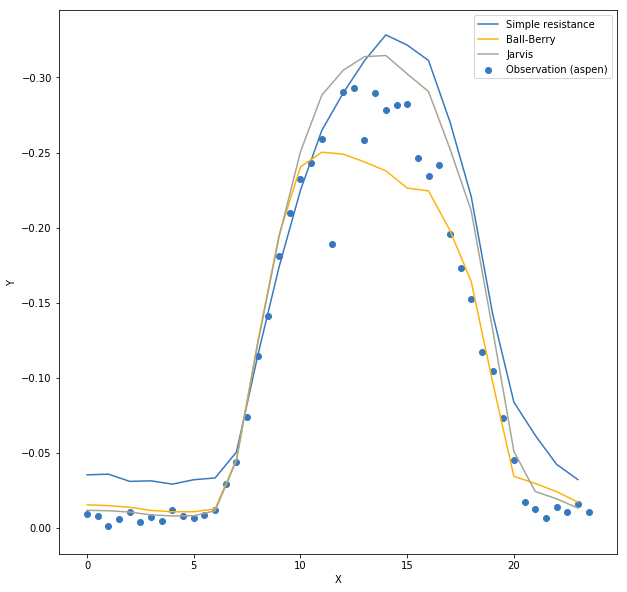

In [27]:
# create plot with three different stomatal resistance parameterizations
ET_Combine_Graph = ET_Combine.plot()
# invert y axis
ET_Combine_Graph.invert_yaxis()
# plot scatter with x='xvals', y='Observation (aspen)'
ET_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'])
# add x, y label
ET_Combine_Graph.set(xlabel='X', ylabel='Y')
# show up the legend
ET_Combine_Graph.legend()

## 5. Discussion

* The simulations in Figure 7 illustrate substantial differences in the estimates of the diurnal cycle of transpiration depending on the choice of stomatal resistance parameterization. 
* The simple soil resistance parameterization [Liang et al., 1994], when combined with the two-source model of within-canopy and below-canopy turbulence [Choudhury and Monteith, 1988; Clark et al., 2015a], results in a substantial amount of transpiration at night when there is no light available for photosynthesis. 
* The physiological representations of transpiration – using the Jarvis and Ball-Berry parameterizations, as defined in Clark et al. [2015a] – have an explicit dependence on photosynthetically active radiation and show the expected result of zero transpiration during nighttime hours, resulting in a poor match with observations (Figure 7).
* A striking result from Figure 7 is that the Ball-Berry parameterization underestimates evapotranspiration when applied using the default model parameters for stomatal resistance in combination with the particular choice of process parameterizations and parameters for soil hydrology.